In ResLT Implementation, I tried to find the best alpha value with these runs. All the code implementation of ResLT in these experiments are the same, but with small adjustments(Augmentation and Lable Smoothing was later added)

## Experiment 1: The paper's alpha value (alpha=0.995)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.995
    IMBALANCE_RATIO = 100 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


100%|██████████| 170M/170M [00:03<00:00, 46.2MB/s]


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 100x
Class Counts: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Epoch 001 | Time: 14.1s | LR: 0.02000 | Loss: 4.3824 | Train Acc: 3.06% | Test Acc: 16.70% | (Many: 0.00%, Medium: 5.27%, Few: 37.80%)
Epoch 002 | Time: 12.0s | LR: 0.04000 | Loss: 4.9988 | Train Acc: 2.97% | Test Acc: 11.32% | (Many: 0.77%, Medium: 3.10%, Few: 25.40%)
Epoch 003 | Time: 12.0s | LR: 0.06000 | Loss: 4.5123 | Train Acc: 14.32% | Test Acc: 14.41% | (Many: 5.90%, Medium: 30.37%, Few: 8.82%)
Epoch 004 | Time: 12.2s | LR: 0.08000 | Loss: 4.4810 | Train Acc: 7.91% | Test Acc: 13.50% | (Many: 0.00%, Medium: 31.47%, Few: 10.15%)
Epoch 005 | Time: 12.9s | LR: 0.10000 | Loss: 4.2872 | Train Acc: 10.95% | Test Acc: 23.12% | (Many: 3.20%, Medium: 32.63%, Few: 30.93%)
Epoch 006 | Time: 12.3s | LR: 0.10000 | Loss: 4.1118 | Train Acc: 4.44% | Test Acc: 20.67% | (Many: 0.03%, Medium: 9.20%, Few: 44.75%)
Epoch 007 | Time: 12.2s | LR: 0.10000 | Loss: 4.226

The model has become a tail-specialist, achieving high accuracy on the rare, few shot classes (78%) but did not perform well on the many shot classes (28%)

So I implemented the other extreme alpha value as next

# Experiment 2: Alpha=0.9

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.9
    IMBALANCE_RATIO = 100 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 100x
Class Counts: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Epoch 001 | Time: 12.7s | LR: 0.02000 | Loss: 4.1608 | Train Acc: 37.26% | Test Acc: 17.61% | (Many: 32.37%, Medium: 19.30%, Few: 5.28%)
Epoch 002 | Time: 12.3s | LR: 0.04000 | Loss: 3.8662 | Train Acc: 16.82% | Test Acc: 17.79% | (Many: 22.97%, Medium: 4.13%, Few: 24.15%)
Epoch 003 | Time: 12.3s | LR: 0.06000 | Loss: 3.7218 | Train Acc: 47.97% | Test Acc: 23.36% | (Many: 43.43%, Medium: 9.87%, Few: 18.43%)
Epoch 004 | Time: 12.3s | LR: 0.08000 | Loss: 3.8138 | Train Acc: 47.66% | Test Acc: 23.41% | (Many: 46.60%, Medium: 24.27%, Few: 5.38%)
Epoch 005 | Time: 12.5s | LR: 0.10000 | Loss: 3.7424 | Train Acc: 39.48% | Test Acc: 21.14% | (Many: 38.73%, Medium: 0.00%, Few: 23.80%)
Epoch 006 | Time: 12.1s | LR: 0.10000 | Loss: 3.6752 | Train Acc: 19.26% | Test Acc: 18.59% | (Many: 25.97%, Medium: 1.70%, Few: 25.73%)
Epoch 007 | Time: 12.3s | LR: 0.10000 | Los

Better accuracy, but became a head specialist. Did very well on Many shot classes (83%) but compartively lower on low shot classes (68%)

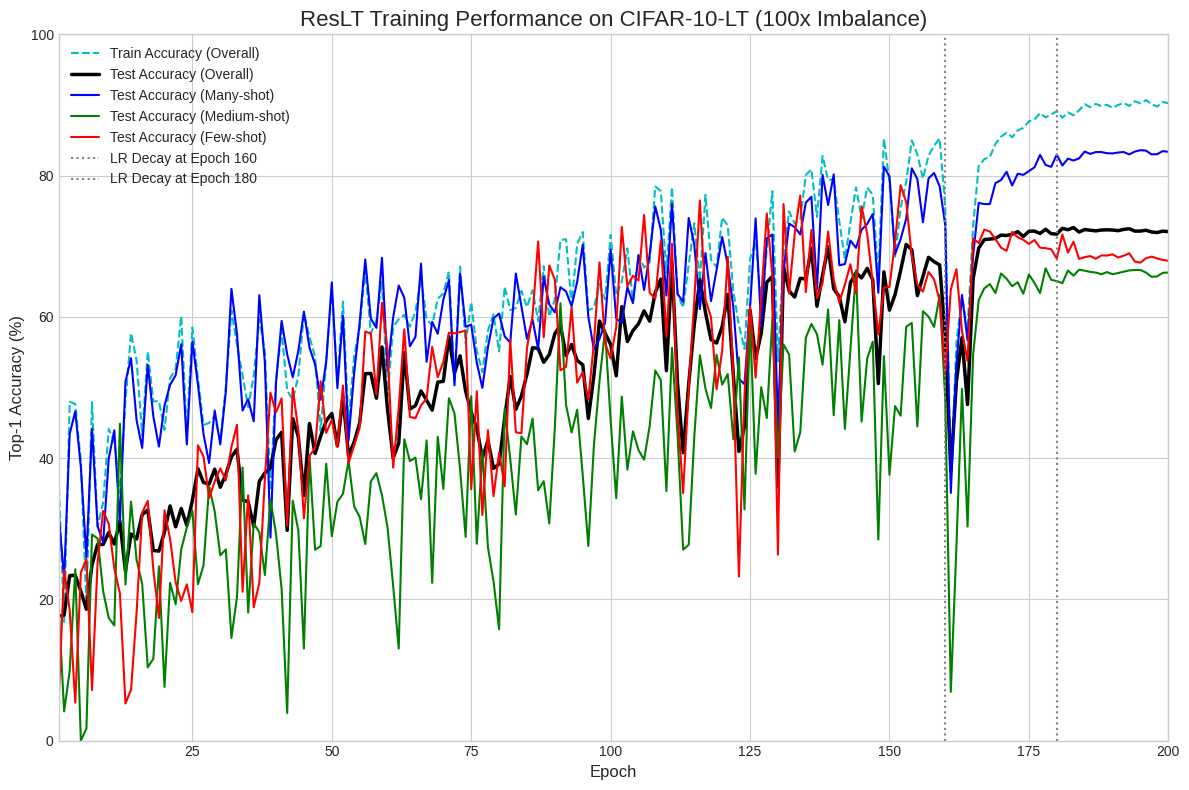

# Experiment 3: alpha=0.99

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.99
    IMBALANCE_RATIO = 100 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


100%|██████████| 170M/170M [00:05<00:00, 31.6MB/s]


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 100x
Class Counts: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Epoch 001 | Time: 13.7s | LR: 0.02000 | Loss: 4.4159 | Train Acc: 2.33% | Test Acc: 16.93% | (Many: 0.00%, Medium: 0.07%, Few: 42.27%)
Epoch 002 | Time: 11.8s | LR: 0.04000 | Loss: 4.2451 | Train Acc: 12.49% | Test Acc: 17.09% | (Many: 7.50%, Medium: 5.63%, Few: 32.88%)
Epoch 003 | Time: 12.0s | LR: 0.06000 | Loss: 4.0996 | Train Acc: 31.90% | Test Acc: 17.64% | (Many: 22.57%, Medium: 18.83%, Few: 13.05%)
Epoch 004 | Time: 11.9s | LR: 0.08000 | Loss: 4.1338 | Train Acc: 2.43% | Test Acc: 19.78% | (Many: 0.03%, Medium: 2.10%, Few: 47.85%)
Epoch 005 | Time: 12.1s | LR: 0.10000 | Loss: 3.8717 | Train Acc: 15.45% | Test Acc: 21.13% | (Many: 9.87%, Medium: 12.53%, Few: 36.02%)
Epoch 006 | Time: 12.1s | LR: 0.10000 | Loss: 3.9761 | Train Acc: 13.40% | Test Acc: 16.89% | (Many: 8.93%, Medium: 29.97%, Few: 13.05%)
Epoch 007 | Time: 11.8s | LR: 0.10000 | Loss: 3

Again produced a tail specialist, so I realized alpha value had to reduced.

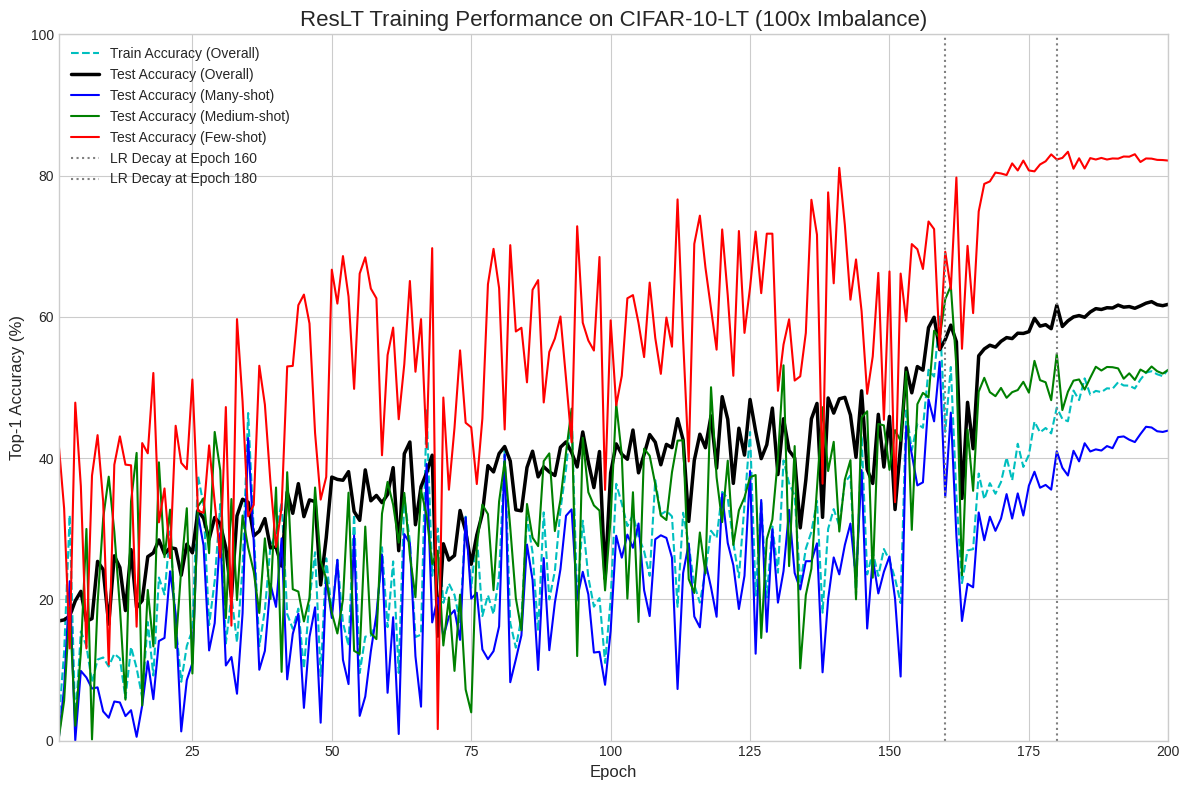

# Experiment 4: alpha=0.95

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.95
    IMBALANCE_RATIO = 100 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


100%|██████████| 170M/170M [00:04<00:00, 37.2MB/s]


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 100x
Class Counts: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Epoch 001 | Time: 13.6s | LR: 0.02000 | Loss: 4.3161 | Train Acc: 8.09% | Test Acc: 15.19% | (Many: 5.57%, Medium: 2.47%, Few: 31.95%)
Epoch 002 | Time: 12.2s | LR: 0.04000 | Loss: 4.0738 | Train Acc: 29.39% | Test Acc: 20.52% | (Many: 23.87%, Medium: 35.00%, Few: 7.15%)
Epoch 003 | Time: 12.0s | LR: 0.06000 | Loss: 4.1524 | Train Acc: 39.29% | Test Acc: 20.40% | (Many: 32.50%, Medium: 27.97%, Few: 5.65%)
Epoch 004 | Time: 11.8s | LR: 0.08000 | Loss: 3.9788 | Train Acc: 13.06% | Test Acc: 19.60% | (Many: 11.23%, Medium: 16.23%, Few: 28.40%)
Epoch 005 | Time: 12.4s | LR: 0.10000 | Loss: 4.0719 | Train Acc: 16.94% | Test Acc: 20.89% | (Many: 11.80%, Medium: 20.97%, Few: 27.65%)
Epoch 006 | Time: 11.8s | LR: 0.10000 | Loss: 3.8786 | Train Acc: 47.75% | Test Acc: 24.03% | (Many: 44.13%, Medium: 23.07%, Few: 9.68%)
Epoch 007 | Time: 11.9s | LR: 0.10000 | Los

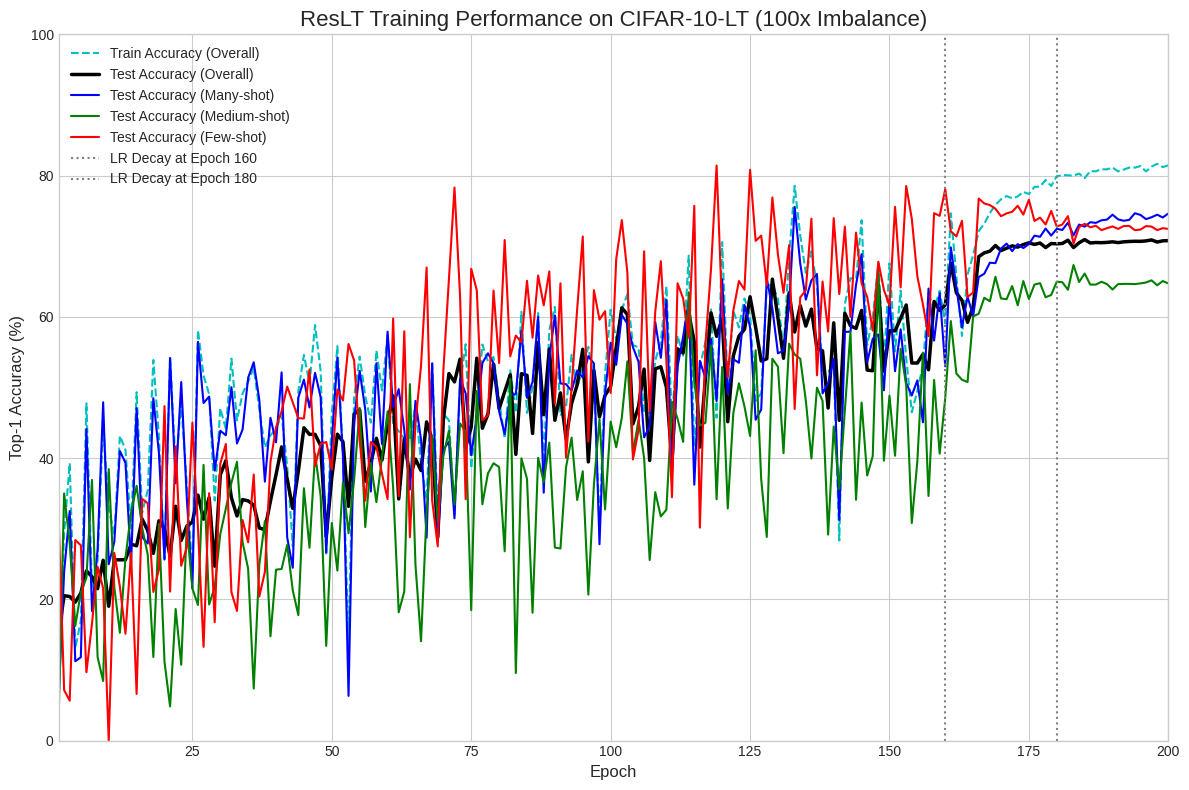

The run with alpha=0.95 was the most balanced. Even though experiment 2 with alpha=0.9, gave me higher accuracy (72%), it was not balanced. But alpha=0.95, despite being lower (70.79), yielded me the most balanced across the many(75%) and few shot classes(72.4%)

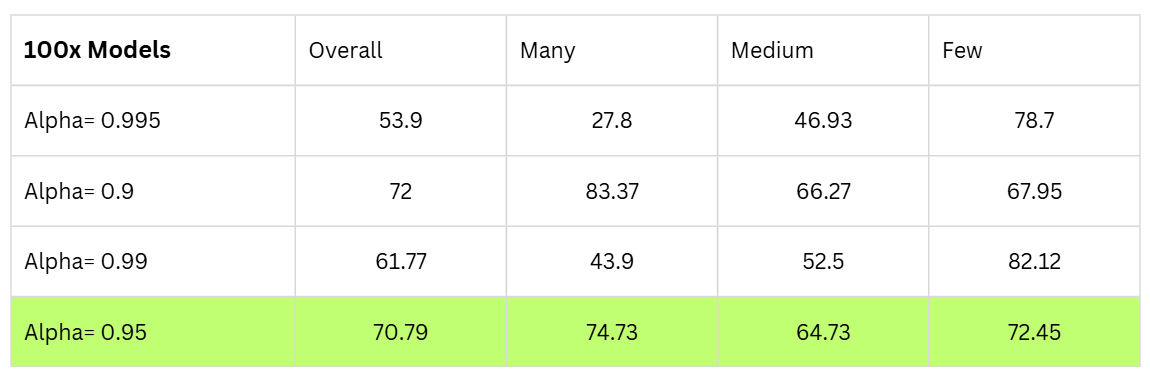

So I finalzed my alpha value as 0.95 and applied a stronger augmentation (AutoAugment) and added label smoothing to yield higher accuracy.

# Alpha=0.95, AutoAugment and Label Smoothing added, 100x,50x,10x

Code for all the models are exactly the same but with 100x, 50x and 10x imbalance ratios.

Below is the run for 100x, alpha=0.95 with AutoAugment and Label Smoothing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.95
    IMBALANCE_RATIO = 100 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 100x
Class Counts: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
Epoch 001 | Time: 19.8s | LR: 0.02000 | Loss: 4.9972 | Train Acc: 31.48% | Test Acc: 12.06% | (Many: 26.50%, Medium: 2.63%, Few: 8.30%)
Epoch 002 | Time: 18.5s | LR: 0.04000 | Loss: 4.9832 | Train Acc: 10.26% | Test Acc: 16.65% | (Many: 3.80%, Medium: 11.60%, Few: 30.07%)
Epoch 003 | Time: 20.0s | LR: 0.06000 | Loss: 4.8724 | Train Acc: 3.90% | Test Acc: 17.60% | (Many: 0.17%, Medium: 7.00%, Few: 38.62%)
Epoch 004 | Time: 19.4s | LR: 0.08000 | Loss: 4.8789 | Train Acc: 15.45% | Test Acc: 16.39% | (Many: 11.07%, Medium: 23.40%, Few: 15.12%)
Epoch 005 | Time: 20.3s | LR: 0.10000 | Loss: 4.7965 | Train Acc: 34.13% | Test Acc: 19.06% | (Many: 28.40%, Medium: 24.33%, Few: 8.10%)
Epoch 006 | Time: 19.1s | LR: 0.10000 | Loss: 4.6598 | Train Acc: 14.00% | Test Acc: 21.17% | (Many: 14.03%, Medium: 1.20%, Few: 41.50%)
Epoch 007 | Time: 20.5s | LR: 0.10000 | Loss:

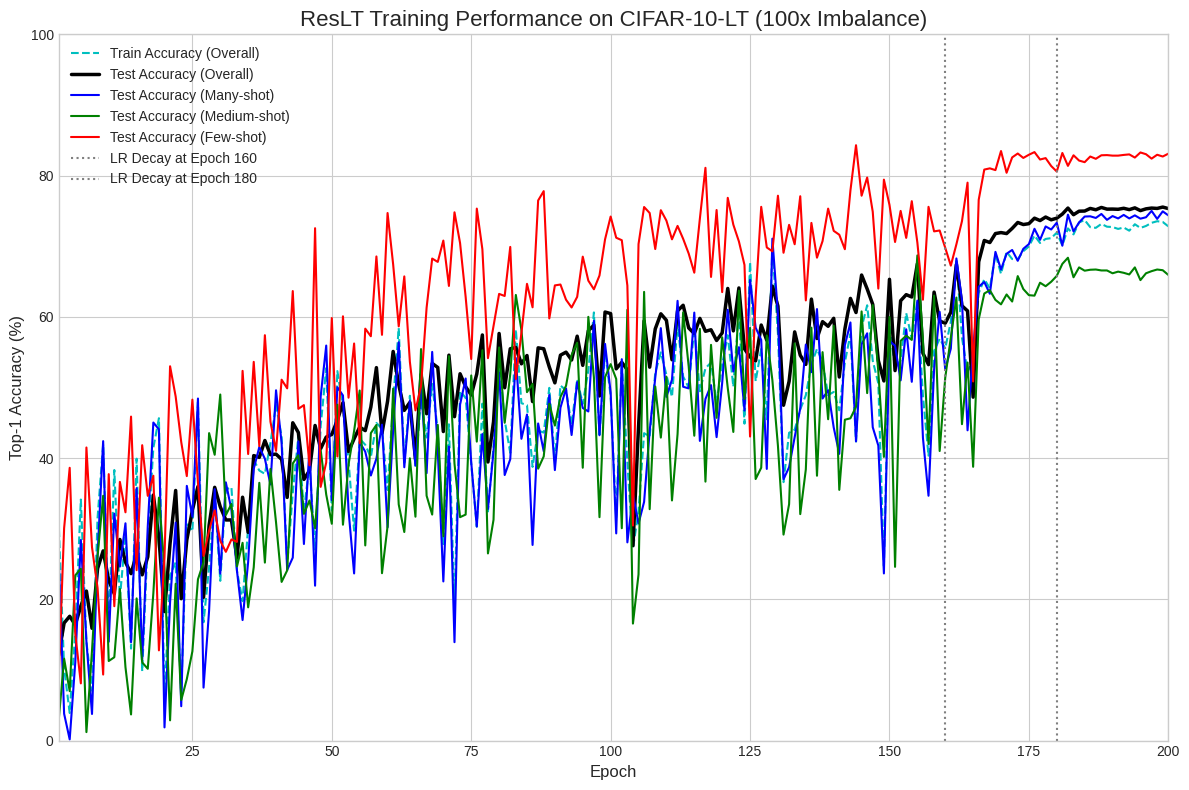

Below is the run for 50x Imbalance Ratio

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.95
    IMBALANCE_RATIO = 50 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


100%|██████████| 170M/170M [00:04<00:00, 37.8MB/s]


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 50x
Class Counts: [5000, 3237, 2096, 1357, 878, 568, 368, 238, 154, 100]
Epoch 001 | Time: 22.4s | LR: 0.02000 | Loss: 5.1557 | Train Acc: 26.39% | Test Acc: 16.94% | (Many: 21.80%, Medium: 3.53%, Few: 23.35%)
Epoch 002 | Time: 22.3s | LR: 0.04000 | Loss: 4.9245 | Train Acc: 11.67% | Test Acc: 19.23% | (Many: 11.10%, Medium: 2.50%, Few: 37.88%)
Epoch 003 | Time: 21.7s | LR: 0.06000 | Loss: 4.8695 | Train Acc: 14.18% | Test Acc: 17.95% | (Many: 10.50%, Medium: 1.17%, Few: 36.12%)
Epoch 004 | Time: 21.2s | LR: 0.08000 | Loss: 4.9217 | Train Acc: 3.45% | Test Acc: 16.44% | (Many: 1.40%, Medium: 0.10%, Few: 39.98%)
Epoch 005 | Time: 21.7s | LR: 0.10000 | Loss: 4.8749 | Train Acc: 12.02% | Test Acc: 19.93% | (Many: 9.60%, Medium: 26.17%, Few: 23.00%)
Epoch 006 | Time: 21.6s | LR: 0.10000 | Loss: 4.7743 | Train Acc: 5.90% | Test Acc: 19.63% | (Many: 6.60%, Medium: 11.43%, Few: 35.55%)
Epoch 007 | Time: 20.6s | LR: 0.10000 | Loss:

Below is the run for 10x Imbalance ratio

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# =============================================================================
# CELL 1: DATASET LOADER
# =============================================================================
def get_cifar10_lt_loaders(batch_size=128, imbalance_ratio=100, root='./data'):
    """Creates long-tailed versions of the CIFAR-10 dataset."""
    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    # Normalization is removed to match ResLT paper's specification [0, 1]
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train_dataset.targets)
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    train_lt_dataset = Subset(full_train_dataset, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

# =============================================================================
# CELL 2: MODEL ARCHITECTURE
# =============================================================================
class ResLT_BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(ResLT_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResLT_ResNet32(nn.Module):
    def __init__(self, block=ResLT_BasicBlock, num_blocks=[5, 5, 5], num_classes=10):
        super(ResLT_ResNet32, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        num_final_features = 48
        self.group_conv = nn.Conv2d(num_final_features, num_final_features * 3, kernel_size=1, groups=3, bias=False)
        self.classifier = nn.Linear(num_final_features, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        features = out.view(out.size(0), -1)
        features_2d = features.view(features.size(0), -1, 1, 1)
        grouped_features = self.group_conv(features_2d)
        grouped_features = grouped_features.view(grouped_features.size(0), 3, -1)
        branch1_feats, branch2_feats, branch3_feats = grouped_features[:, 0, :], grouped_features[:, 1, :], grouped_features[:, 2, :]
        out1, out2, out3 = self.classifier(branch1_feats), self.classifier(branch2_feats), self.classifier(branch3_feats)
        return out1, out2, out3

# =============================================================================
# CELL 3: TRAINING AND EVALUATION SCRIPT
# =============================================================================

def train_reslt(model, train_loader, optimizer, criterion, alpha, class_splits, device):
    """Training function specific to ResLT's loss calculation."""
    model.train()
    total_loss = 0

    # Unpack class splits
    many_shot, medium_shot, few_shot = class_splits['many'], class_splits['medium'], class_splits['few']

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out1, out2, out3 = model(images)

        # --- ResLT Loss Calculation ---
        # 1. Fusion Loss (L_fusion)
        loss_fusion = criterion(out1 + out2 + out3, labels)

        # 2. Branch-Independent Loss (L_branch)
        loss_branch1 = criterion(out1, labels)

        medium_tail_mask = torch.isin(labels, torch.tensor(medium_shot + few_shot).to(device))
        tail_mask = torch.isin(labels, torch.tensor(few_shot).to(device))

        loss_branch2 = criterion(out2[medium_tail_mask], labels[medium_tail_mask]) if medium_tail_mask.sum() > 0 else 0
        loss_branch3 = criterion(out3[tail_mask], labels[tail_mask]) if tail_mask.sum() > 0 else 0

        loss_branch = loss_branch1 + loss_branch2 + loss_branch3

        # 3. Final Combined Loss
        final_loss = (1 - alpha) * loss_fusion + alpha * loss_branch

        final_loss.backward()
        optimizer.step()
        total_loss += final_loss.item()

    return total_loss / len(train_loader)

def evaluate_reslt(model, data_loader, class_splits, device):
    """Evaluation function for ResLT model."""
    model.eval()
    correct = {k: 0 for k in class_splits.keys()}
    total = {k: 0 for k in class_splits.keys()}
    correct['all'], total['all'] = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            out1, out2, out3 = model(images)
            fused_output = out1 + out2 + out3
            _, predicted = torch.max(fused_output.data, 1)

            total['all'] += labels.size(0)
            correct['all'] += (predicted == labels).sum().item()

            for i, label in enumerate(labels):
                label_item = label.item()
                if label_item in class_splits['many']:
                    total['many'] += 1
                    if predicted[i] == label: correct['many'] += 1
                elif label_item in class_splits['medium']:
                    total['medium'] += 1
                    if predicted[i] == label: correct['medium'] += 1
                elif label_item in class_splits['few']:
                    total['few'] += 1
                    if predicted[i] == label: correct['few'] += 1

    accuracies = {k: 100 * correct[k] / total[k] if total[k] > 0 else 0 for k in total}
    return accuracies

def main_reslt():
    # --- Hyperparameters ---
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    BASE_LR = 0.1
    MOMENTUM = 0.9
    ALPHA = 0.95
    IMBALANCE_RATIO = 10 # Change to 10, 50, or 100
    WARMUP_EPOCHS = 5

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader, class_counts = get_cifar10_lt_loaders(BATCH_SIZE, IMBALANCE_RATIO)

    class_splits = {
        'many': [0, 1, 2],
        'medium': [3, 4, 5],
        'few': [6, 7, 8, 9]
    }

    model = ResLT_ResNet32(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=2e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

    # Lists to store accuracy history
    history = {
        'train_acc': [], 'test_acc': [],
        'test_acc_many': [], 'test_acc_medium': [], 'test_acc_few': []
    }

    print("--- Starting ResLT Training ---")
    print(f"Device: {device}, Imbalance Ratio: {IMBALANCE_RATIO}x")
    print(f"Class Counts: {class_counts}")

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # Learning Rate Warmup
        if epoch < WARMUP_EPOCHS:
            current_lr = BASE_LR * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
        else:
            current_lr = scheduler.get_last_lr()[0]

        avg_loss = train_reslt(model, train_loader, optimizer, criterion, ALPHA, class_splits, device)

        if epoch >= WARMUP_EPOCHS:
            scheduler.step()

        # --- Evaluation ---
        train_accuracies = evaluate_reslt(model, train_loader, class_splits, device)
        test_accuracies = evaluate_reslt(model, test_loader, class_splits, device)

        # Append all results to history dictionary
        history['train_acc'].append(train_accuracies['all'])
        history['test_acc'].append(test_accuracies['all'])
        history['test_acc_many'].append(test_accuracies['many'])
        history['test_acc_medium'].append(test_accuracies['medium'])
        history['test_acc_few'].append(test_accuracies['few'])

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_accuracies['all']:.2f}% | Test Acc: {test_accuracies['all']:.2f}% | "
              f"(Many: {test_accuracies['many']:.2f}%, Medium: {test_accuracies['medium']:.2f}%, Few: {test_accuracies['few']:.2f}%)")

    print("\nTraining complete.")

    # Save the model and accuracy histories
    model_save_path = f"reslt_resnet32_cifar10_imbalance_{IMBALANCE_RATIO}.pth"
    torch.save(model.state_dict(), model_save_path)

    # Save all history lists
    for key, values in history.items():
        np.save(f"reslt_{key}_imbalance_{IMBALANCE_RATIO}.npy", np.array(values))

    print(f"Model saved to {model_save_path}")
    print("All accuracy histories saved.")

# Direct execution for Colab/Jupyter environments
main_reslt()


100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s]


--- Starting ResLT Training ---
Device: cuda, Imbalance Ratio: 10x
Class Counts: [5000, 3871, 2997, 2320, 1796, 1391, 1077, 834, 645, 500]
Epoch 001 | Time: 32.1s | LR: 0.02000 | Loss: 5.2648 | Train Acc: 15.78% | Test Acc: 24.16% | (Many: 22.17%, Medium: 0.30%, Few: 43.55%)
Epoch 002 | Time: 28.9s | LR: 0.04000 | Loss: 5.0474 | Train Acc: 8.46% | Test Acc: 19.97% | (Many: 1.20%, Medium: 2.63%, Few: 47.05%)
Epoch 003 | Time: 28.9s | LR: 0.06000 | Loss: 4.8675 | Train Acc: 10.16% | Test Acc: 24.07% | (Many: 2.30%, Medium: 2.67%, Few: 56.45%)
Epoch 004 | Time: 29.2s | LR: 0.08000 | Loss: 4.7176 | Train Acc: 12.13% | Test Acc: 25.48% | (Many: 1.87%, Medium: 27.23%, Few: 41.88%)
Epoch 005 | Time: 29.4s | LR: 0.10000 | Loss: 4.4540 | Train Acc: 16.57% | Test Acc: 38.76% | (Many: 3.37%, Medium: 22.20%, Few: 77.72%)
Epoch 006 | Time: 29.3s | LR: 0.10000 | Loss: 4.2187 | Train Acc: 23.67% | Test Acc: 40.73% | (Many: 22.97%, Medium: 14.13%, Few: 74.00%)
Epoch 007 | Time: 28.8s | LR: 0.10000 | L

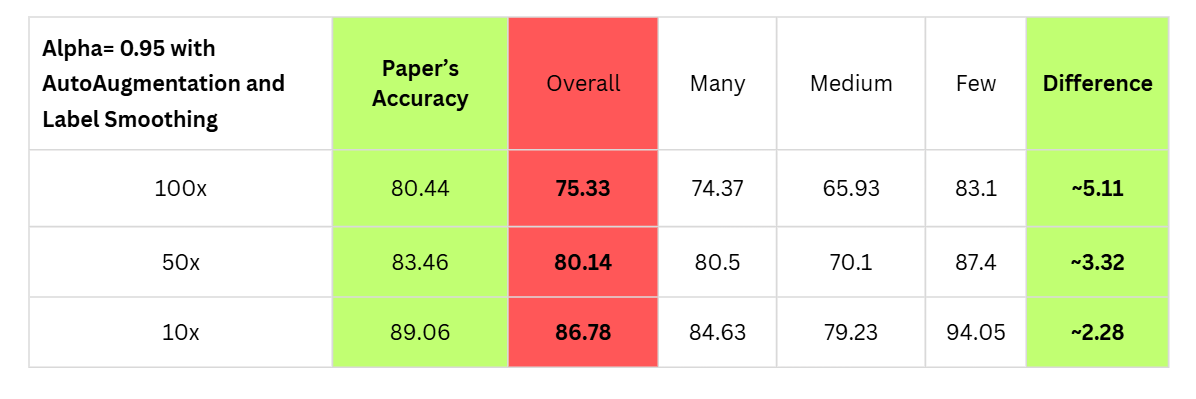